# Fake News Detection In Arabic Newspapers

### imports

In [50]:
import os
import pandas as pd
import itertools
import numpy as np
import string
import re
import matplotlib.pyplot as plt

import pickle

from sklearn import preprocessing
import matplotlib
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,SpatialDropout1D
from keras.layers.embeddings import Embedding


# Stemming

from nltk.stem import SnowballStemmer


## Normalisation

### remove diacritics

In [51]:
def removeDiacretics(news_list):

    arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    temp_list = list()
    for news in news_list:
        text = re.sub(arabic_diacritics, '', news)
        temp_list.append(text)

    return temp_list


### get top n words

In [52]:
def get_top_n_words(corpus, n=None):
   
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


### normalise arabic

In [53]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

### other normalisations

In [54]:


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

def remove_punctuations(text):
    translator = str.maketrans(' ', ' ', punctuations_list)
    return text.translate(translator)

def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

### remove ponctuations

In [55]:

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|"!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations


### stopwords

In [56]:

stop_words = set(stopwords.words('arabic'))


### normalise arabic

In [57]:
def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    return(text)


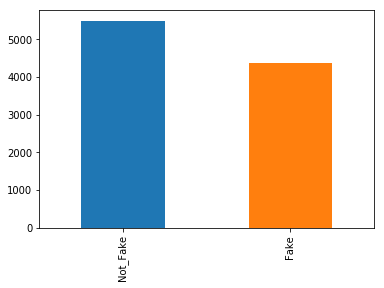

In [58]:

ar_stemmer = SnowballStemmer("arabic")

trainDF1 = pd.read_csv("dataset.csv", delimiter=",", encoding='utf-8')
trainDF2 = pd.read_csv("dataset2.csv", delimiter=",", encoding='utf-8')

trainDF = pd.concat([trainDF1,trainDF2])

trainDF.text[0]

pd.DataFrame(trainDF.text[0]).to_csv("1.csv",index=False)



trainDF['label'].value_counts().plot(kind='bar')




### Apply normalise to all dataset

In [59]:
def normalizeDF(df):

    for index, row in df.iterrows():

        text = df.iloc[index].text
        
        if type(text) == str:
            
            text = remove_punctuations(text).rstrip()

            text = removeDiacretics([text])

            word_tokens = word_tokenize(text[0])

            filtered_sentence = [w for w in word_tokens if not w in stop_words]

            stemmed_words = [ar_stemmer.stem(word) for word in filtered_sentence]

            stemmed_sentence = ' '.join(stemmed_words)

            df.iloc[index].text = stemmed_sentence

    return df

In [60]:

filtered_df = normalizeDF(trainDF)

myinp = filtered_df.text[0]

pd.DataFrame(filtered_df.text[0]).to_csv("2.csv",index=False)

filtered_df.to_csv('to_train.csv', sep=',')

print(filtered_df.head())

filtered_df.to_csv('to_train.csv', sep=',')

print("filtered")



                                                text     label
0  اسوا مكتب ارشاد يمل نايب عام قرار انج خليف قال...  Not_Fake
1  قضا دول نتسلم الان حكم عود نايب عام سابق قاهر ...  Not_Fake
2  عضو ب « شورى » يطالب مرس اعل طوارء تشكيل محا ث...  Not_Fake
3  نياب عام طلع عبد الله نايب عام حال باق منصب بق...  Not_Fake
4  سرع انتر مصر تنخفض 60 انقطاع كابل حرى قال سيم ...  Not_Fake
filtered


#### split dataset 

In [61]:
train_x, test_x, train_y, test_y = train_test_split(trainDF['text'].values, trainDF['label'].values,test_size=0.2)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(7891,) (7891,)
(1973,) (1973,)


### tfidfVectorizer

In [66]:

max_fatures = 500

# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word',max_features=5000)
tfidf_vect.fit(trainDF['text'].values.astype('U'))


print(type(train_x))
print(train_x.shape)
xtrain_tfidf = tfidf_vect.transform(train_x.astype('U')).toarray()

xvalid_tfidf = tfidf_vect.transform(test_x.astype('U')).toarray()

pickle.dump(tfidf_vect, open("vectorizer.pickle", "wb"))

mdl2 = pickle.load(open("vectorizer.pickle","rb"))

myinp = '''


الصح 18 حال وفا و 3 اصاب فى حادث منطاد اقصر اعل دكتور خالد خطيب رييس ادار مركز رعا عاجل حرج زار الصح عدد حال وفا فى حادث حريق و انفجار منطاد اقصر اثناء هبوط وصل 18 حال وفا و3 مصاب اوضح خطيب تصريح يوم قتلى 4 يابا و9 صين رنس اثن مجر وانجليزى اضاف مواط مصر مشير حصر وفق بيا وارد شرك مسيول رحل مدير الصح اقصر ولف مصاب ثلاث ريطا مصر يخضع علاج مستشفى اقصر دولى تراوح حال اصاب حروق درج ثلاث جروح متعدد كسور كان دكتور محمد مصطفى حامد زير الصح والس اصدر تعليم نقل ضحا اسعاف طاير قاهر مصاب حادث مستشفى معهد ناصر وقد توج صباح يوم ريق طب رياس دكتور محمد سلط رييس هيء اسعاف مصر اقصر قوف حال مصاب طير بال قان مطابق مواصف واحترق اثناء هبو فى سياق متصل اكد رييس سلط طير مدن محمد ابراهيم شريف بال سقط محافظ اقصر صعيد مصر صباح يومالثلاثاء واد ال مصرع 19 سايح كان مرخص يعمل شكل قان طبق تعليم مواصف تنص زار طير مدن قال ابراهيم تصريح صحف يومالثلاثاءء لجن حوادث بدء تحقيق لفحص ملابس حادث معرف اسباب حقيق اضاف حريق نشب بال اثناء محاول تثب عمال ارض مرحل هبوط مساف 3 امتار ارض اقلع مر ثان وف اثناء قفز ركاب هروب طيار ارتفع بال ال اعل اد ال زياد اشتعال فعل عوامل الجو قال معروف مندوب شرك مطار يقوم مخاطب ارصاد الجو معرف سرع رياح واتج ومد ملايم اجواء اقلاع بال يقوم تنسيق الجه مختلف معرف عدد مناطيد اخر اما سماء تحدث مصادم اجراء سلامةمش ال بال يقسم ال اربع اجزاء جزء يسع خمس ركاب اضاف ال جزء مخصص طيار


'''

print(train_x[0])



myinp0 = tfidf_vect.transform(np.array([train_x[0]]).astype('U')).toarray()
myinpvect = mdl2.transform(np.array([myinp]).astype('U')).toarray()



pd.DataFrame(myinp0).to_csv("k1.csv")
pd.DataFrame(myinpvect).to_csv("k2.csv")


pd.DataFrame(xtrain_tfidf[0]).to_csv("1.csv")
# save model


print(xtrain_tfidf.shape)
print(xvalid_tfidf.shape)

# load model 

<class 'numpy.ndarray'>
(7891,)
ضبط 8 بلا بلو قاهر اكد مدير امن قاهر بيا رسم انه تم قاء قبض 8 اشخاص منتم جماع بلا بلو دواير اقسام مدير منهم قام قطع طريق عام ضبط حوز ذخير حي مولوتوف تمك خدم امن داير قسم عابد ضبط محمد فهم محمد 30س عاطل مقيم لبيس شرق حوز طبنج صوت مار راو معدل حي و50 طلق مواج اقر انضمام حديث مجموع بلا بلو وان حصل سلاح طلق احد اعضاء تسليم اخر تحرر محضر رقم 8402013 جنح عابد عرض نياب قرر حبس اربع ايام تجديد حبس امر اخلاء سبيل كفال مال وف مد نصر القى رجال شرط قبض احمد ابو قاسم عويض صحف جريد شباب مصر كتر مقيم عمرا جيز مرتد قناع اسود مناقش قرر انه اثناء تواجد شارع مكرم عبيد توقف طريق عام امس لاف ورق مدو عايز تقبض بلا بلو اقبض اخو عايز تقبض بلا بلو اقبض منقب عايز تقبض بلا بلو قتل اخو فى اتحاد اقبض اخو اضاف بان ينتم جماع بلا بلو وان اراد توصيل رسال جماهير قايم حكم اضاف انه دايم انتقاد مقال اعمال شغب قطع طرق تحرر محضر رقم 3192013 جنح قسم شرط مد نصر اول عرض نياب قرر اخلاء سبيل و تمك مباحث لاق ابو الع قبض احمد ناج محمد جبر سن21طالب مقيم شبر خيم قليوب حوز طلق ال قناع اسود خاص مجموع بل

### CountVectorizer

In [68]:

count_vec = CountVectorizer(analyzer='word', max_features=5000)
count_train = count_vec.fit(trainDF['text'].values.astype('U'))
bag_of_words_train = count_vec.transform(train_x.astype('U')).toarray()
bag_of_words_test = count_vec.transform(test_x.astype('U')).toarray()



print(bag_of_words_train.shape)
print(bag_of_words_test.shape)


(7891, 5000)
(1973, 5000)


## Logistic Regression +TfIdfVectorizer

(1973,)
(7891,)
Validation Accuracy : 0.8596046629498226
(1973,)
(1973,)
Confusion matrix, without normalization
[[802 232]
 [ 45 894]]
Normalized confusion matrix
[[0.78 0.22]
 [0.05 0.95]]


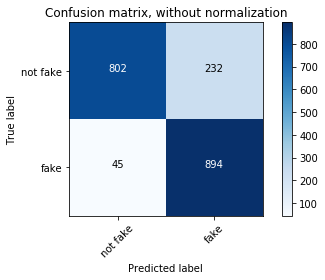

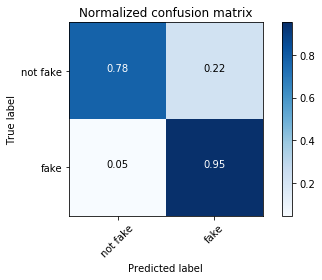

In [69]:

# Fitting the Logistic Regression into the Training set



from sklearn.metrics import accuracy_score




from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(xtrain_tfidf, train_y)


# save resulting model


pickle.dump(classifier, open("logistic_reg.pickle", "wb"))

# Predicting the test set results

tested_y = classifier.predict(xvalid_tfidf)

print(tested_y.shape)
print(train_y.shape)

print('Validation Accuracy : ' + str(accuracy_score(test_y, tested_y)))




# Making the Confusion Matrix

print(tested_y.shape)
print(test_y.shape)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(tested_y, test_y)

def plot_confusion_matrix(cm, classes=['not fake','fake'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, normalize=True,
                      title='Normalized confusion matrix')

plt.show()



## Logistic Regression + CountVectorizer

(1973,)
(1973,)
Validation Accuracy : 0.8443993917891536
(1973,)
(1973,)
Confusion matrix, without normalization
[[707 167]
 [140 959]]
Normalized confusion matrix
[[0.81 0.19]
 [0.13 0.87]]


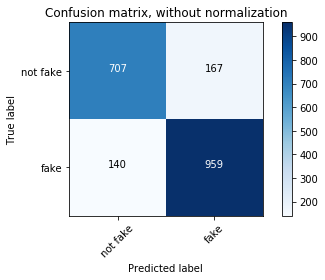

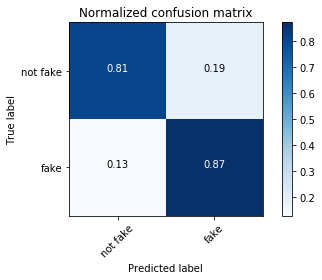

In [70]:

classifier = LogisticRegression(random_state = 0)
classifier.fit(bag_of_words_train, train_y)

# Predicting the test set results

tested_y = classifier.predict(bag_of_words_test)

print(tested_y.shape)
print(test_y.shape)

print('Validation Accuracy : ' + str(accuracy_score(test_y, tested_y)))

# Making the Confusion Matrix

print(tested_y.shape)
print(test_y.shape)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(tested_y, test_y)

def plot_confusion_matrix(cm, classes=['not fake','fake'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


## Naive Bayes

(1973,)
(7891,)
Validation Accuracy : 0.8449062341611758
(1973,)
(1973,)
Confusion matrix, without normalization
[[844 303]
 [  3 823]]
Normalized confusion matrix
[[0.74 0.26]
 [0.   1.  ]]


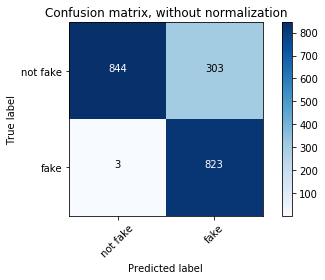

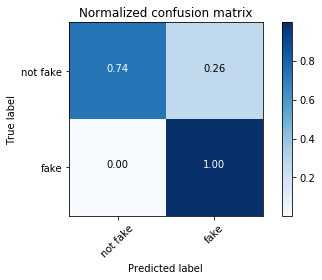

In [72]:
from sklearn.naive_bayes import MultinomialNB

model1 = MultinomialNB().fit( xtrain_tfidf, train_y)

# save model

pickle.dump(model1, open("nayve_bayes.pickle", "wb"))


tested_y = model1.predict(xvalid_tfidf)


print(tested_y.shape)
print(train_y.shape)

print('Validation Accuracy : ' + str(accuracy_score(test_y, tested_y)))


print(tested_y.shape)
print(test_y.shape)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(tested_y, test_y)

def plot_confusion_matrix(cm, classes=['not fake','fake'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, normalize=True,
                      title='Normalized confusion matrix')

plt.show()




## Random Forest Classifier

Validation Accuracy : 0.8667004561581348
(1973,)
(1973,)
Confusion matrix, without normalization
[[820 236]
 [ 27 890]]
Normalized confusion matrix
[[0.78 0.22]
 [0.03 0.97]]


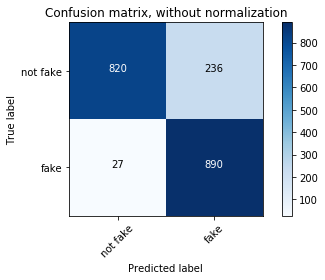

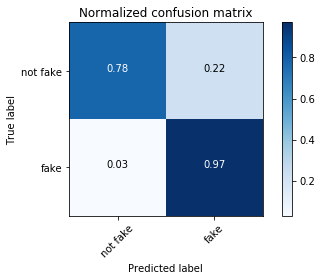

In [74]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)



#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(bag_of_words_train, train_y)

# save model

pickle.dump(clf, open("random_forest.pickle", "wb"))



tested_y=clf.predict(bag_of_words_test)


print('Validation Accuracy : ' + str(accuracy_score(test_y, tested_y)))


print(tested_y.shape)
print(test_y.shape)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(tested_y, test_y)

def plot_confusion_matrix(cm, classes=['not fake','fake'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, normalize=True,
                      title='Normalized confusion matrix')

plt.show()



In [ ]:
news_input = '''

الصح 18 حال وفا و 3 اصاب فى حادث منطاد اقصر اعل دكتور خالد خطيب رييس ادار مركز رعا عاجل حرج زار الصح عدد حال وفا فى حادث حريق و انفجار منطاد اقصر اثناء هبوط وصل 18 حال وفا و3 مصاب اوضح خطيب تصريح يوم قتلى 4 يابا و9 صين رنس اثن مجر وانجليزى اضاف مواط مصر مشير حصر وفق بيا وارد شرك مسيول رحل مدير الصح اقصر ولف مصاب ثلاث ريطا مصر يخضع علاج مستشفى اقصر دولى تراوح حال اصاب حروق درج ثلاث جروح متعدد كسور كان دكتور محمد مصطفى حامد زير الصح والس اصدر تعليم نقل ضحا اسعاف طاير قاهر مصاب حادث مستشفى معهد ناصر وقد توج صباح يوم ريق طب رياس دكتور محمد سلط رييس هيء اسعاف مصر اقصر قوف حال مصاب طير بال قان مطابق مواصف واحترق اثناء هبو فى سياق متصل اكد رييس سلط طير مدن محمد ابراهيم شريف بال سقط محافظ اقصر صعيد مصر صباح يومالثلاثاء واد ال مصرع 19 سايح كان مرخص يعمل شكل قان طبق تعليم مواصف تنص زار طير مدن قال ابراهيم تصريح صحف يومالثلاثاءء لجن حوادث بدء تحقيق لفحص ملابس حادث معرف اسباب حقيق اضاف حريق نشب بال اثناء محاول تثب عمال ارض مرحل هبوط مساف 3 امتار ارض اقلع مر ثان وف اثناء قفز ركاب هروب طيار ارتفع بال ال اعل اد ال زياد اشتعال فعل عوامل الجو قال معروف مندوب شرك مطار يقوم مخاطب ارصاد الجو معرف سرع رياح واتج ومد ملايم اجواء اقلاع بال يقوم تنسيق الجه مختلف معرف عدد مناطيد اخر اما سماء تحدث مصادم اجراء سلامةمش ال بال يقسم ال اربع اجزاء جزء يسع خمس ركاب اضاف ال جزء مخصص طيار
'''
print(news_input)

empty_list = list()
empty_list.append(news_input)
    
print(empty_list)

filtered_df = normalizeDF(pd.DataFrame(empty_list,columns=['text']))

print("here")

print(filtered_df)



    
model1_name = "logistic_reg.pickle"
model2_name = "nayve_bayes.pickle"
model3_name = "random_forest.pickle"

print('on est la mon frere')    
    
    

loaded_model1 = pickle.load(open(model1_name, 'rb'))
loaded_model2 = pickle.load(open(model2_name, 'rb'))
loaded_model3 = pickle.load(open(model3_name, 'rb'))
    
tfidfvect = pickle.load(open("vectorizer.pickle","rb"))


news_vector = tfidfvect.transform(filtered_df.values.astype('U')[0]).toarray()

pd.DataFrame(filtered_df.values).to_csv("k3.csv")

pd.DataFrame(news_vector).to_csv("K4.csv")

print(loaded_model1.predict(news_vector))
print(loaded_model2.predict(news_vector))
print(loaded_model3.predict(news_vector))
    
print('loaded_model')
    



In [ ]:
import keras

Y = pd.get_dummies(train_y)
Y_t = pd.get_dummies(test_y)


model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(5000,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
cnnhistory=model.fit(bag_of_words_train.reshape((7398,5000,1)), Y, batch_size=32, epochs=10, validation_data=(bag_of_words_test, y_t))


In [ ]:
import keras

Y = pd.get_dummies(train_y)
Y_t = pd.get_dummies(test_y)


model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(5000,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=(8)))
model.add(LSTM(100))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
cnnhistory=model.fit(bag_of_words_train.reshape((7398,5000,1)), Y, batch_size=32, epochs=10, validation_data=(bag_of_words_test, y_t))


## Long Short Term Memory